In [1]:
import numpy as np
import cvxopt as cv
import math
from sklearn import svm,multiclass
import time
import matplotlib.pyplot as plt
TRAIN_FILE = 'fashion_mnist/train.csv'
TEST_FILE = 'fashion_mnist/test.csv'
VAL_FILE = 'fashion_mnist/val.csv'

In [2]:
# Load data from files
data = np.genfromtxt(TRAIN_FILE,delimiter=',')
tdata = np.genfromtxt(TEST_FILE,delimiter=',')
vdata = np.genfromtxt(VAL_FILE,delimiter=',')

In [3]:
C = 1.0
y = 0.05

# Binary Classifier

In [4]:
# Define classes to classify
d = 0
classes = [d, (d+1)%10] # Binary classification 

In [5]:
# Loading and modifying traindata
# change values to [0,1] from [0,255]
indices = np.where(data[:,-1] < 2)
X = data[indices,0:784][0] / 255.0
# change classes to {-1,1}
Y = 2* data[indices,-1] -1 

In [6]:
# Loading test data
indices = np.where(tdata[:,-1] < 2)
tY = 2 * (tdata[indices,-1])[0] -1
tX = (tdata[indices,0:784]/255.0)[0]

# Loading validation data
indices = np.where(vdata[:,-1] < 2)
vY = 2 * (vdata[indices,-1])[0] - 1
vX = (vdata[indices,0:784]/255.0)[0]

In [88]:
# returns alphas as np array, train for both linear and gaussian
def train(islinear,X,Y):
    M = len(X)
    P = np.eye(M).astype(float)
    if(islinear):
        print("Using Linear Kernel")
        # linear kernel
        Z = Y.T * X
        ## M x M array Linear kernel
        P = np.matmul(Z, Z.T)
    else:
        print("Using Gaussian Kernel")
        for i in range(0,M):
            t = X - X[i]
            P[i] = np.sum(t**2,axis=1)
        P = np.matmul(Y.T,Y) * GAUS(y,P)
    P = cv.matrix(P)
    # column vector with all -1
    Q = cv.matrix(-1 * np.ones((M,1)).astype(float))
    G = cv.matrix(np.vstack((-1 * np.eye(M).astype(float),np.eye(M).astype(float))))
    h = cv.matrix(np.vstack((np.zeros((M,1)).astype(float),C * np.ones((M,1)).astype(float))))
    A = cv.matrix(Y)
    b = cv.matrix([[0]],tc='d')
    print("Finding the optimal solution:")
    solution = cv.solvers.qp(P,Q,G,h,A,b)
    return np.array(solution['x'])

In [89]:
# Gaussian Kernel
def gaussian(y,v):
    return math.exp(-y * v)
GAUS = np.vectorize(gaussian)

In [90]:
def traingaus(GP,Y,M):
#     M = len(Y)
    print("Training on gaussian kernel")
    P = cv.matrix(np.matmul(Y.T,Y) * GP)
    # column vector with all -1
    Q = cv.matrix(-1 * np.ones((M,1)).astype(float))
    G = cv.matrix(np.vstack((-1 * np.eye(M).astype(float),np.eye(M).astype(float))))
    h = cv.matrix(np.vstack((np.zeros((M,1)).astype(float),C * np.ones((M,1)).astype(float))))
    A = cv.matrix(Y)
    b = cv.matrix([[0]],tc='d')
    print("Finding the optimal solution:")
    solution = cv.solvers.qp(P,Q,G,h,A,b)
    return np.array(solution['x'])

In [91]:
def getB(ALPHA,GP):
    R = np.sum(ALPHA * GP, axis=0)
    M = len(R)
    ## assuming arangement is such that top layers is Y = -1 and bottom is Y = 1
    maxv = np.max(R[0:M/2])
    minv = np.min(R[M/2:])
    b = -(maxv + minv)/2.0
    return b

### Linear Kernel

In [92]:
def getLinearParams(alph,X,Y):
    fw = alph * Y.T
    w = np.matmul(fw.T,X)
    R = np.matmul(w,X.T)[0]
    Y = Y[0]
    y1indices = np.where(Y==1)
    y0indices = np.where(Y==-1)
    maxv = np.max(R[y0indices])
    minv = np.min(R[y1indices])
    b = -(maxv+minv)/2.0
    nsv = len(np.where(alph > 1e-05)[0])
    return (w,b,nsv)

In [95]:
linearalpha = train(True,X,Y)
(W,b,nsv) = getLinearParams(linearalpha,X,Y)

Using Linear Kernel
Finding the optimal solution:
     pcost       dcost       gap    pres   dres
 0: -3.2916e+02 -9.3878e+03  5e+04  3e+00  3e-12
 1: -2.0018e+02 -5.2391e+03  1e+04  4e-01  2e-12
 2: -9.3627e+01 -1.6503e+03  3e+03  8e-02  1e-12
 3: -5.1870e+01 -7.1316e+02  1e+03  3e-02  8e-13
 4: -2.9393e+01 -4.7263e+02  7e+02  2e-02  5e-13
 5: -1.8616e+01 -2.5482e+02  4e+02  7e-03  4e-13
 6: -1.5942e+01 -8.1551e+01  9e+01  2e-03  4e-13
 7: -1.7889e+01 -4.1759e+01  3e+01  4e-04  4e-13
 8: -1.9475e+01 -3.1857e+01  1e+01  8e-05  4e-13
 9: -1.9419e+01 -2.8941e+01  1e+01  3e-16  4e-13
10: -2.1921e+01 -2.4878e+01  3e+00  9e-16  4e-13
11: -2.2590e+01 -2.3752e+01  1e+00  2e-16  4e-13
12: -2.3023e+01 -2.3203e+01  2e-01  4e-15  4e-13
13: -2.3099e+01 -2.3108e+01  1e-02  2e-15  4e-13
14: -2.3103e+01 -2.3103e+01  2e-04  5e-15  4e-13
15: -2.3103e+01 -2.3103e+01  2e-06  9e-16  4e-13
Optimal solution found.


In [96]:
print("Number of Support Vectors: "+str(nsv))

Number of Support Vectors: 198


In [97]:
print("b: "+str(b))

b: -1.6282084222780322


In [98]:
# Test data
testValues = (np.matmul(W,tX.T) + b)[0]
testPrediction = [1 if val>=0 else -1 for val in testValues]
testCorrect = len(np.where(testPrediction == tY)[0])
testAccuracy = float(testCorrect)/float(len(tY))
print("Test Accuracy: " + str(testAccuracy))

Test Accuracy: 0.982


In [99]:
# validation data
validationValues = (np.matmul(W,vX.T) + b)[0]
validationPrediction = [1 if val >=0 else -1 for val in validationValues]
validationCorrect = len(np.where(validationPrediction==vY)[0])
validationAccuracy = float(validationCorrect)/float(len(vY))
print("Validation Accuracy: "+str(validationAccuracy))

Validation Accuracy: 0.974


### Gaussian Kernel

In [100]:
# Calculate Squared sum matrix
M = len(X)
SSM = np.eye(M).astype(float)
for i in range(0,M):
    SSM[i] = np.sum((X-X[i])**2,axis=1)
# Gaussian of SSM
GM = GAUS(y,SSM)

In [101]:
gaussianalpha = traingaus(GM,Y,M)

Training on gaussian kernel
Finding the optimal solution:
     pcost       dcost       gap    pres   dres
 0: -1.6492e+02 -6.6070e+03  3e+04  2e+00  1e-15
 1: -1.1407e+02 -3.0686e+03  5e+03  2e-01  2e-15
 2: -1.0459e+02 -7.6952e+02  9e+02  3e-02  2e-15
 3: -1.2684e+02 -3.0203e+02  2e+02  6e-03  2e-15
 4: -1.4133e+02 -2.0101e+02  6e+01  1e-03  1e-15
 5: -1.4945e+02 -1.6809e+02  2e+01  2e-04  1e-15
 6: -1.5144e+02 -1.6280e+02  1e+01  3e-05  1e-15
 7: -1.5364e+02 -1.5728e+02  4e+00  7e-06  1e-15
 8: -1.5443e+02 -1.5550e+02  1e+00  9e-16  1e-15
 9: -1.5478e+02 -1.5492e+02  1e-01  7e-15  1e-15
10: -1.5483e+02 -1.5484e+02  4e-03  1e-14  1e-15
11: -1.5483e+02 -1.5483e+02  6e-05  1e-14  1e-15
Optimal solution found.


In [102]:
fW = gaussianalpha * Y.T

In [103]:
nsv = len(np.where(gaussianalpha>1e-05)[0])
print("Number of Support Vectors: "+str(nsv))

Number of Support Vectors: 834


In [104]:
# Get B
tmp = np.sum(fW * GM, axis=0)
y1indices = np.where(Y[0]==1)
yn1indices = np.where(Y[0]==-1)
maxv = np.max(tmp[yn1indices])
minv = np.min(tmp[y1indices])
b = -(maxv + minv)/2.0
print("b: "+str(b))

b: -0.0009552690776055139


In [105]:
# Test data
tSSM = np.ones((len(X),len(tX))).astype(float)
for i in range(0,len(X)):
    tSSM[i] = np.sum((tX - X[i])**2,axis = 1)
tGM = GAUS(y,tSSM)
testValues = np.sum(fW* tGM, axis=0) + b
testPrediction = [1 if val>=0 else -1 for val in testValues]
testCorrect = len(np.where(testPrediction == tY)[0])
testAccuracy = float(testCorrect)/float(len(tY))
print("Test Accuracy: " + str(testAccuracy))

Test Accuracy: 0.993


In [106]:
# Validation data
vSSM = np.ones((len(X),len(vX))).astype(float)
for i in range(0,len(X)):
    vSSM[i] = np.sum((vX - X[i])**2,axis = 1)
vGM = GAUS(y,vSSM)
validationValues = np.sum(fW* vGM, axis=0) + b
validationPrediction = [1 if val>=0 else -1 for val in validationValues]
validationCorrect = len(np.where(validationPrediction == vY)[0])
validationAccuracy = float(validationCorrect)/float(len(vY))
print("Validation Accuracy: " + str(validationAccuracy))

Validation Accuracy: 0.978


## sklearn svm

### Linear Kernel

In [7]:
# Training
linearclf = svm.SVC(C=1.0,kernel='linear')
linearclf.fit(X,Y[0])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [8]:
print("Number of Support Vectors = "+str(np.sum(linearclf.n_support_)))

Number of Support Vectors = 198


In [9]:
# Test data
R = linearclf.predict(tX)
Correct = len(np.where(R == tY)[0])
print("Test Accuracy: "+str(float(Correct)/float(len(R))))

Test Accuracy: 0.98


In [10]:
# Validation data
R = linearclf.predict(vX)
Correct = len(np.where(R == vY)[0])
print("Validation Accuracy: "+str(float(Correct)/float(len(R))))

Validation Accuracy: 0.978


### Gaussian Kernel

In [11]:
# Training
gaussianclf = svm.SVC(C=1.0,kernel='rbf',gamma=y)
gaussianclf.fit(X,Y[0])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.05, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [12]:
print("Number of Support Vectors = "+str(np.sum(gaussianclf.n_support_)))

Number of Support Vectors = 811


In [13]:
# Test data
R = gaussianclf.predict(tX)
Correct = len(np.where(R == tY)[0])
print("Test Accuracy: "+str(float(Correct)/float(len(R))))

Test Accuracy: 0.989


In [14]:
# Validation data
R = gaussianclf.predict(vX)
Correct = len(np.where(R == vY)[0])
print("Validation Accuracy: "+str(float(Correct)/float(len(R))))

Validation Accuracy: 0.986


# Multi Class Classifier

In [15]:
# Load data
allX = data[:,0:784] / 255.0
Y = data[:,-1]

In [16]:
# create a dict containing all rows for a class in class key
X = {}
for i in range(0,len(allX)):
    if Y[i] not in X:
        X[Y[i]] = [allX[i]]
    else:
        X[Y[i]].append(allX[i])

In [17]:
## Alphas and b for different classes
ALPHAxY = np.zeros((10,10,4500,1)).astype(float)
b = np.zeros((10,10)).astype(float)

In [18]:
# Load saved Alphas and b
ALPHAxY = np.load('alphxy.npy')
b = np.load('b.npy')

In [19]:
def ip(G,X,i):
    G[i] = np.sum((X-X[i])**2, axis=1)
IP = np.vectorize(ip)

In [12]:
# fill upper triangle with alphas
Yi = np.ones(2250).astype(float)
st = time.time()
for i in range(0,10):
    for j in range(i+1,10):
        print("training for "+str(i) + " " + str(j))
        trainX = np.vstack((X[i],X[j]))
        # treating bigger class as 1 and smaller as -1
        trainY = np.asarray([np.hstack((-1.0*Yi,Yi))]).astype(float)
        GP = np.eye(len(trainX)).astype(float)
        M = len(trainX)
        for f in range(0,M):
#             t = trainX - trainX[f]
#             GP[f] = np.sum(t*t,axis=1)
            GP[f] = np.sum((trainX - trainX[f])**2,axis=1)
        GP = GAUS(y,GP)
        ALPHAxY[i][j] = (traingaus(GP,trainY,M) * trainY.T)
        b[i][j] = getB(ALPHAxY[i][j],GP)
        print(time.time()-st)

training for 0 1
Training on gaussian kernel
Finding the optimal solution:
     pcost       dcost       gap    pres   dres
 0: -1.6492e+02 -6.6070e+03  3e+04  2e+00  4e-15
 1: -1.1407e+02 -3.0686e+03  5e+03  2e-01  4e-15
 2: -1.0459e+02 -7.6952e+02  9e+02  3e-02  4e-15
 3: -1.2684e+02 -3.0203e+02  2e+02  6e-03  4e-15
 4: -1.4133e+02 -2.0101e+02  6e+01  1e-03  3e-15
 5: -1.4945e+02 -1.6809e+02  2e+01  2e-04  3e-15
 6: -1.5144e+02 -1.6280e+02  1e+01  3e-05  3e-15
 7: -1.5364e+02 -1.5728e+02  4e+00  7e-06  3e-15
 8: -1.5443e+02 -1.5550e+02  1e+00  7e-14  3e-15
 9: -1.5478e+02 -1.5492e+02  1e-01  2e-13  3e-15
10: -1.5483e+02 -1.5484e+02  4e-03  5e-14  4e-15
11: -1.5483e+02 -1.5483e+02  6e-05  2e-14  4e-15
Optimal solution found.
131.822613955
training for 0 2
Training on gaussian kernel
Finding the optimal solution:
     pcost       dcost       gap    pres   dres
 0: -3.7366e+02 -8.4330e+03  4e+04  2e+00  4e-15
 1: -2.8341e+02 -4.5691e+03  7e+03  2e-01  5e-15
 2: -2.6181e+02 -1.1549e+03  1

 4: -1.0877e+02 -1.5571e+02  5e+01  7e-04  2e-15
 5: -1.1554e+02 -1.3286e+02  2e+01  1e-04  2e-15
 6: -1.1887e+02 -1.2384e+02  5e+00  2e-06  2e-15
 7: -1.2010e+02 -1.2121e+02  1e+00  3e-14  2e-15
 8: -1.2044e+02 -1.2063e+02  2e-01  1e-13  2e-15
 9: -1.2051e+02 -1.2052e+02  1e-02  2e-15  2e-15
10: -1.2052e+02 -1.2052e+02  2e-04  9e-14  2e-15
11: -1.2052e+02 -1.2052e+02  9e-06  1e-13  2e-15
Optimal solution found.
1410.99896193
training for 1 5
Training on gaussian kernel
Finding the optimal solution:
     pcost       dcost       gap    pres   dres
 0: -9.3956e+01 -6.5185e+03  3e+04  2e+00  2e-15
 1: -5.0069e+01 -2.9491e+03  5e+03  2e-01  2e-15
 2: -3.9046e+01 -6.7825e+02  8e+02  3e-02  2e-15
 3: -6.0172e+01 -2.0557e+02  2e+02  5e-03  2e-15
 4: -7.2614e+01 -1.1949e+02  5e+01  1e-03  2e-15
 5: -7.7575e+01 -9.6388e+01  2e+01  1e-04  1e-15
 6: -7.9825e+01 -8.8992e+01  9e+00  2e-13  1e-15
 7: -8.1322e+01 -8.4537e+01  3e+00  2e-13  1e-15
 8: -8.1909e+01 -8.3041e+01  1e+00  7e-14  1e-15
 9: -8

 6: -2.6583e+02 -2.6927e+02  3e+00  2e-05  2e-15
 7: -2.6678e+02 -2.6733e+02  6e-01  3e-06  2e-15
 8: -2.6696e+02 -2.6699e+02  3e-02  1e-07  2e-15
 9: -2.6697e+02 -2.6697e+02  6e-04  2e-09  2e-15
10: -2.6697e+02 -2.6697e+02  1e-05  2e-11  2e-15
Optimal solution found.
2682.92416501
training for 2 9
Training on gaussian kernel
Finding the optimal solution:
     pcost       dcost       gap    pres   dres
 0: -1.3122e+02 -6.8313e+03  3e+04  2e+00  3e-15
 1: -6.8632e+01 -3.3021e+03  5e+03  2e-01  2e-15
 2: -4.4226e+01 -5.7527e+02  6e+02  2e-02  3e-15
 3: -8.9948e+01 -1.9526e+02  1e+02  2e-03  2e-15
 4: -1.0529e+02 -1.3890e+02  3e+01  6e-04  1e-15
 5: -1.1181e+02 -1.2245e+02  1e+01  1e-04  1e-15
 6: -1.1461e+02 -1.1691e+02  2e+00  8e-06  1e-15
 7: -1.1534e+02 -1.1566e+02  3e-01  3e-07  1e-15
 8: -1.1546e+02 -1.1548e+02  2e-02  4e-09  1e-15
 9: -1.1546e+02 -1.1547e+02  5e-04  1e-10  1e-15
10: -1.1546e+02 -1.1546e+02  1e-05  2e-12  1e-15
Optimal solution found.
2794.06880093
training for 3 4


Training on gaussian kernel
Finding the optimal solution:
     pcost       dcost       gap    pres   dres
 0: -1.1407e+02 -6.5885e+03  3e+04  2e+00  3e-15
 1: -5.4731e+01 -3.0743e+03  5e+03  2e-01  2e-15
 2: -3.3614e+01 -5.3901e+02  6e+02  2e-02  3e-15
 3: -7.3851e+01 -1.8900e+02  1e+02  3e-03  2e-15
 4: -8.8826e+01 -1.2601e+02  4e+01  7e-04  1e-15
 5: -9.4967e+01 -1.0838e+02  1e+01  2e-04  1e-15
 6: -9.7972e+01 -1.0158e+02  4e+00  2e-05  1e-15
 7: -9.8948e+01 -9.9746e+01  8e-01  2e-06  9e-16
 8: -9.9202e+01 -9.9319e+01  1e-01  2e-07  9e-16
 9: -9.9246e+01 -9.9249e+01  3e-03  3e-09  1e-15
10: -9.9248e+01 -9.9248e+01  7e-05  7e-11  1e-15
Optimal solution found.
4056.41380787
training for 5 6
Training on gaussian kernel
Finding the optimal solution:
     pcost       dcost       gap    pres   dres
 0: -2.0533e+02 -7.5506e+03  3e+04  2e+00  3e-15
 1: -1.2813e+02 -3.9857e+03  6e+03  2e-01  2e-15
 2: -9.5987e+01 -7.8644e+02  8e+02  2e-02  3e-15
 3: -1.4760e+02 -3.3431e+02  2e+02  5e-03  2e-1

In [85]:
# save generated Alphaxy and B
np.save('alphxy.npy',ALPHAxY.astype(np.float32))
np.save('b.npy',b)

In [126]:
# Testing, returns accuracy and cnfmat, assuming ALPHAxY and b are defined globally
def testing(tX,tY):
    M = 4500
    Votes = np.zeros((45,len(tX))).astype(np.int64)
    tx = np.ones((M,len(tX))).astype(float)
    st = time.time()
    index = 0
    # Iterate over all i,j to get vote from each classifier
    for i in range(0,10):
        for j in range(i+1,10):
            print("Voting b/w classes "+str(i) + " and "+ str(j))
            trainX = np.vstack((X[i],X[j]))
            for k in range(0,M):
                tx[k] = np.sum((tX - trainX[k])**2,axis = 1)
            fW = ALPHAxY[i][j]
            R = np.sum(fW * GAUS(y,tx), axis=0) + b[i][j]
            # converting values to classes
            v = [j if cls>=0 else i for cls in R]
            Votes[index] = v
            index+=1
    Votes = Votes.T
    # Create Final class from votes, tie ends with assigning max class
    R = np.zeros(len(tX))
    for i in range(0,len(tX)):
        tmp = np.bincount(Votes[i])
        R[i] = np.where(tmp == tmp.max())[0][-1]
    cnfmat = np.zeros((10,10))
    # Number of correct predictions
    correct = len(np.where(R == tY)[0])
    accuracy = float(correct)/float(len(tY))
    for i in range(0,len(tY)):
        cnfmat[int(R[i])][int(tY[i])] +=1
    return (accuracy,cnfmat)

In [125]:
# Test data
tX = tdata[:,0:784]/255.0
tY = tdata[:,-1]
(TestAccuracy, TestConfusionMatrix) = testing(tX,tY)
print("Test Accuracy: "+str(TestAccuracy))
print("Confusion Matrix for Test data:")
print(TestConfusionMatrix)

In [122]:
# Validation data
vX = vdata[:,0:784]/255.0
vY = vdata[:,-1]
(ValidationAccuracy,ValidationConfusionMatrix) = testing(vX,vY)
print("Validation Accuracy: "+str(ValidationAccuracy))
print("Confusion Matrix for Validation data:")
print(ValidationConfusionMatrix)

## sklearn svm

In [20]:
# Multi class using SK learn 1 vs 1
# Initialize classifier
classifier = multiclass.OneVsOneClassifier(svm.SVC(kernel='rbf',C=1,gamma=0.05))

In [22]:
# Train
st = time.time()
classifier.fit(allX,Y)
print(time.time() - st)

251.799129009


In [138]:
# assuming classifier is global
def svmtesting(tX,tY):
    R = classifier.predict(tX)
    cnfmat = np.zeros((10,10)).astype(int)
    correct = len(np.where(R==tY)[0])
    for i in range(0,len(R)):
        cnfmat[int(R[i])][int(tY[i])]+=1
    accuracy = float(correct)/float(len(tY))
    return (accuracy,cnfmat)

In [139]:
# Test data
tX = tdata[:,0:784]/255.0
tY = tdata[:,-1]
(TestAccuracy, TestConfusionMatrix) = svmtesting(tX,tY)
print("Test Accuracy: "+str(TestAccuracy))
print("Confusion Matrix for Test data:")
print(TestConfusionMatrix)

Test Accuracy: 0.881
Confusion Matrix for Test data:
[[433   1   5  12   2   0  80   0   1   0]
 [  0 482   0   0   1   0   0   0   0   0]
 [  5   4 410   3  39   0  53   0   1   0]
 [ 11   9   7 457  14   0   9   0   1   0]
 [  3   0  37   9 399   0  34   0   2   0]
 [  0   0   0   0   0 473   0  14   2  11]
 [ 38   4  33  14  39   0 317   0   2   0]
 [  0   0   0   0   0  16   0 471   2  14]
 [ 10   0   8   5   6   5   7   1 489   1]
 [  0   0   0   0   0   6   0  14   0 474]]


In [140]:
# Validation data
vX = vdata[:,0:784]/255.0
vY = vdata[:,-1]
(ValidationAccuracy,ValidationConfusionMatrix) = svmtesting(vX,vY)
print("Validation Accuracy: "+str(ValidationAccuracy))
print("Confusion Matrix for Validation data:")
print(ValidationConfusionMatrix)

Validation Accuracy: 0.8788
Confusion Matrix for Validation data:
[[212   0   5   6   1   0  33   0   0   0]
 [  0 237   0   0   1   0   0   0   0   0]
 [  1   3 205   0  24   0  28   0   1   0]
 [  8   7   3 228   8   1   4   0   1   0]
 [  0   0  19   6 200   0  19   0   1   0]
 [  0   0   0   0   0 241   0   8   0   5]
 [ 26   2  13   9  15   0 165   0   1   0]
 [  0   0   0   0   0   2   0 230   2   8]
 [  3   1   5   1   1   1   1   1 244   2]
 [  0   0   0   0   0   5   0  11   0 235]]


### Finding C

In [149]:
Cs = [1e-5,1e-3,1,5,10]

In [141]:
AX = allX
AY = Y

In [178]:
LIM = 5000

In [179]:
allX = AX[0:LIM]
Y = AY[0:LIM]

In [180]:
tX = tdata[0:LIM,0:784]/255.0
tY = tdata[0:LIM,-1]
vX = vdata[:,0:784]/255.0
vY = vdata[:,-1]

In [182]:
# K-cross validation
# assuming data is already shuffled
k = 5
BS = allX.shape[0]/k
Accuracies=[]
st = time.time()
for c in Cs:
    correct = 0
    clf = multiclass.OneVsOneClassifier(svm.SVC(kernel='rbf',C=c,gamma=0.05))
    # Treat i-th block as validation set
    for i in range(0,k):
        print("Block "+str(i+1))
        trainX = np.vstack((allX[:i*BS],allX[(i+1)*BS:]))
        trainY = np.hstack((Y[:i*BS],Y[(i+1)*BS:]))
        clf.fit(trainX,trainY)
        R = clf.predict(allX[i*BS:(i+1)*BS])
        y = Y[i*BS:(i+1)*BS]
        correct += len(np.where(R==y)[0])
    Accuracy = float(correct)/float(len(allX))
    Accuracies.append(Accuracy)
    print("C: "+str(c)+", " + "Average Validation accuracy: "+str(Accuracy))
print(Accuracies)

Block 1
Block 2


KeyboardInterrupt: 

In [ ]:
# Test and Validation Accuracies
TestAccuracies = []
ValidationAccuracies = []
for c in Cs:
    clf = multiclass.OneVsOneClassifier(svm.SVC(kernel='rbf',C=c,gamma=0.05))
    clf.fit(allX,Y)
    testCorrect = len(np.where(clf.predict(tX)==tY)[0])
    testAccuracy = float(testCorrect)/float(len(tY)) 
    TestAccuracies.append(testAccuracy)
    validationCorrect = len(np.where(clf.predict(vX)==vY)[0])
    validationAccuracy = float(validationCorrect)/float(len(vY))
    ValidationAccuracies.append(validationAccuracy)
    print("C: "+str(c)+", Test data Accuracy: "+str(testAccuracy)+", Validation data Accuracy: "+str(validationAccuracy))

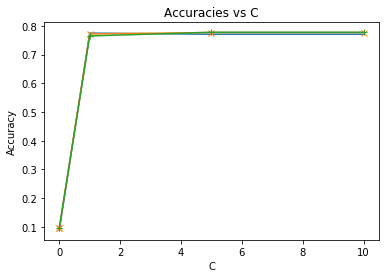

In [177]:
plt.plot(Cs,Accuracies)
plt.plot(Cs,TestAccuracies,marker='x')
plt.plot(Cs,ValidationAccuracies,marker='+')
plt.title("Accuracies vs C")
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.savefig('Accuracies')